# **Dependencies**
### opencv-python, matplotlib, pytesseract, PyDrive

In [1]:
!pip3 install opencv-python

In [2]:
!pip3 install opencv-contrib-python

In [3]:
!pip3 install matplotlib

In [4]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (3,770 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [5]:
!pip install PyDrive

# Imports

In [0]:
import cv2

In [0]:
import numpy as np

In [0]:
import os

In [0]:
import pytesseract

In [0]:
import matplotlib.pyplot as plt


In [0]:
%matplotlib inline

In [12]:
print(cv2.__version__)


4.1.2


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

In [0]:
def plot_side_by_side(image1, image2, title1="", title2="", width=15, height=15, cmap="gray"):
  fig = plt.figure(figsize=[width, height])
  ax1 = fig.add_subplot(121)
  ax1.imshow(image1, cmap=cmap)
  ax1.set(xticks=[], yticks=[], title=title1)

  ax2 = fig.add_subplot(122)
  ax2.imshow(image2, cmap=cmap)
  ax2.set(xticks=[], yticks=[], title=title2)

In [0]:
from google.colab.patches import cv2_imshow

In [80]:
upload_files()

Saving amcarimage.jpg to amcarimage (1).jpg


['amcarimage.jpg']

In [0]:
path = "./amcarimage.jpg"

In [82]:
upload_files()

Saving cascade.xml to cascade (1).xml


['cascade.xml']

In [0]:
path1="./cascade.xml"

In [0]:
watch_cascade = cv2.CascadeClassifier(path1)

In [85]:
image = cv2.imread(path)
print(image.size)

1440000


<class 'numpy.ndarray'>
imagecolorcropped


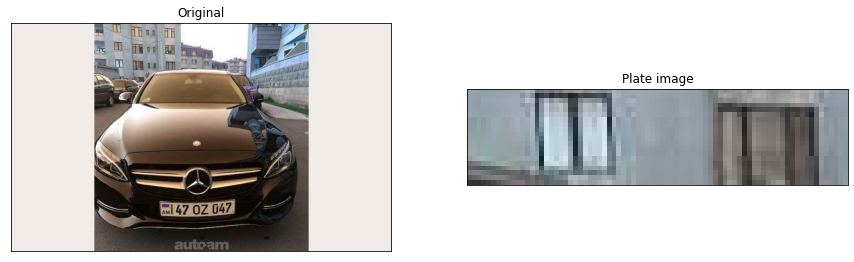

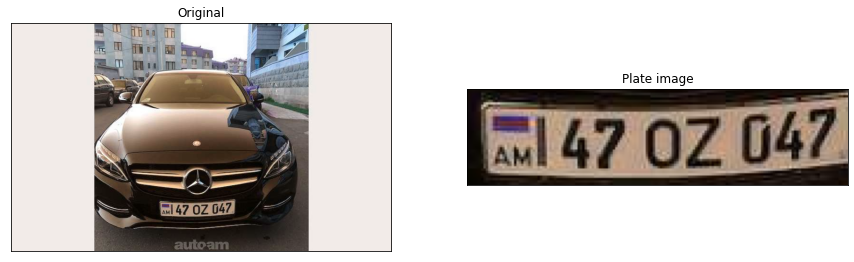

In [95]:
def detectPlateRough(image_gray,resize_h = 720,en_scale =1.08 ,top_bottom_padding_rate = 0.05):
        if top_bottom_padding_rate>0.2:
            print("error:top_bottom_padding_rate > 0.2:",top_bottom_padding_rate)
            exit(1)
        height = image_gray.shape[0]
        padding = int(height*top_bottom_padding_rate)
        scale = image_gray.shape[1]/float(image_gray.shape[0])
        image = cv2.resize(image_gray, (int(scale*resize_h), resize_h))
        image_color_cropped = image[padding:resize_h-padding,0:image_gray.shape[1]]
        print(type(image_color_cropped))
        print('imagecolorcropped')
        image_gray = cv2.cvtColor(image_color_cropped,cv2.COLOR_RGB2GRAY)
        watches = watch_cascade.detectMultiScale(image_gray, en_scale, 2, minSize=(36, 9),maxSize=(36*40, 9*40))
        cropped_images = []
        plate_numbers=[]
        for (x, y, w, h) in watches:

            

            x -= w * 0.14
            w += w * 0.28
            y -= h * 0.15
            h += h * 0.3

            

            cropped = cropImage(image_color_cropped, (int(x), int(y), int(w), int(h)))
            cropped_images.append(cropped)
            
        return cropped_images

def cropImage(image,rect):
        x, y, w, h = computeSafeRegion(image.shape,rect)
        plot_side_by_side(image, image[y:y+h,x:x+w], title1="Original", title2="Plate image")
        cv2.waitKey(0)
        return image[y:y+h,x:x+w]


def computeSafeRegion(shape,bounding_rect):
        top = bounding_rect[1] # y
        bottom  = bounding_rect[1] + bounding_rect[3] # y +  h
        left = bounding_rect[0] # x
        right =   bounding_rect[0] + bounding_rect[2] # x +  w
        min_top = 0
        max_bottom = shape[0]
        min_left = 0
        max_right = shape[1]

        
        if top < min_top:
            top = min_top
        if left < min_left:
            left = min_left
        if bottom > max_bottom:
            bottom = max_bottom
        if right > max_right:
            right = max_right
        return [left,top,right-left,bottom-top]   

images = detectPlateRough(image,image.shape[0],top_bottom_padding_rate=0.1)

In [96]:
print(len(images))

2


In [0]:

from PIL import Image

In [0]:
def resizeImage(imgPath='plate.png'):
  im=Image.open(imgPath)
  length_x, width_y= im.size
  factor=min(1,float(1024.0/length_x))
  size=int(factor*length_x),int(factor*width_y)
  im_resized=im.resize(size,Image.ANTIALIAS)
  return im_resized

In [0]:
def secondCrop(img):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,127,255,0)
    contours,_ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]
    if(len(areas)!=0):
        max_index = np.argmax(areas)
        cnt=contours[max_index]
        x,y,w,h = cv2.boundingRect(cnt)
        bounds = cv2.boundingRect(cnt)
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        secondCrop = img[y:y+h,x:x+w]
    else:
        secondCrop = img
    return secondCrop

In [0]:
number_plate = None

In [101]:
for plate in images:
  cv2.imwrite("plate.png", plate)
  resizedImage = np.asarray(resizeImage('plate.png'))
  croppedImage= secondCrop(resizedImage)
  gray_plate = cv2.cvtColor(croppedImage, cv2.COLOR_BGR2GRAY)
  plate_blur=cv2.blur(gray_plate,(5,5))
#plate_blur=cv2.medianBlur(gray_plate,5)
  plate_blur = cv2.blur(plate_blur,(2,2))
  conf=('-l eng --oem 3 --psm 8')
  text = pytesseract.image_to_string(plate_blur,config=conf)
  print(text)
  if len(text)>=9:
    number_plate=text
    print(number_plate[-9:])
    break

  



7147 OZ 047
47 OZ 047


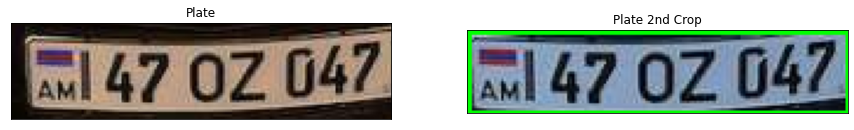

In [102]:
plot_side_by_side(plate, croppedImage, title1="Plate", title2="Plate 2nd Crop")

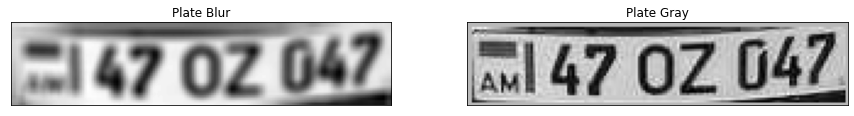

In [103]:
plot_side_by_side(plate_blur, gray_plate, title1="Plate Blur", title2="Plate Gray")